# **Sensors and Sensing Course**
## Home Assignment 2

Nabila Adawy


B19-RO-01


n.roshdy@innopolis.university

### **To run the code:**


Upload this file to colab notebook and "case1.txt","Images.zip"files to test the code.

### **Importing all the libraries we need.**

In [187]:
from matplotlib.pyplot import *
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Task 1

In this task we have measured values for the pitch angle from a gyroscope. Our goal is to estimate a proper trajectory for the pitch angle using Kalman Filter.


First of all, we will import our data from ('case1.txt') file and visualize it.

### **Data Loading and Vislualization.**

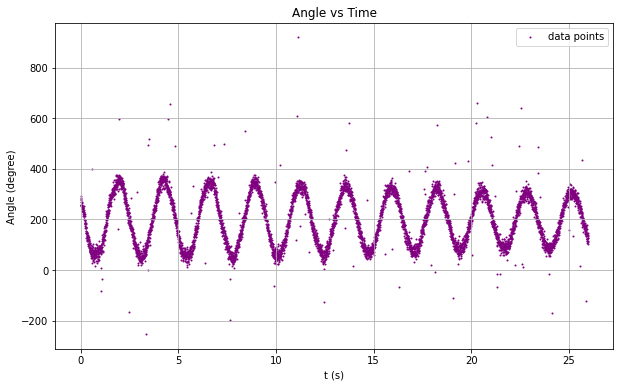

In [188]:
file = open('case1.txt', 'r')
time, angle = [], []

for i in file:
  point = i.strip().split(',')
  time.append(float(point[0]))
  angle.append(float(point[1]))

figure(figsize=(10,6))
scatter(time, angle , s=1, label="data points", color ='purple')
title('Angle vs Time')
ylabel('Angle (degree)')
xlabel('t (s)')
legend()
grid()
show()

### **Kalman Filter.**

Using one dimensional Kalman Filter which is based on the motion and sensor models represented by the following equations::

- $ x_{n+1} = x_n + u_n + \epsilon_n $  , $\epsilon_k$ represents the error in the motion model
- $ z_n = x_n + \eta_n $ , $\eta_n$ represents the noise in the sensor data


the main equations used to estimate the optimal model after filtering and obtaining the Kalman Filter coefficients as follows:

- $ x_{n+1}^{opt} = K*z_{n+1} + (1-K) *(x_n^{opt} + u_n) $

- $ e_{n+1}^{opt} = E(e_{n+1}) = \sqrt{\frac{\sigma_{\eta}^2(E(e_n^2) + \sigma_{\epsilon}^2)}{E(e_n^2) + \sigma_{\epsilon}^2 + \sigma_{\eta}^2}} $ 

- $ K_{n+1} = \frac{{e_{n+1}^{opt}}^2}{\sigma_{\eta}^2} $ 

where $z_n$ is the sensor readings and $k_n$ is the kalman gain at time n. $\sigma_{\epsilon}$ and $\sigma_{\eta}$ are assumed values.


In [189]:
N = len(angle)
sigma_psi = 10
sigma_eta = np.sqrt(np.var(angle))

x_opt = np.zeros(N)
e_opt = np.zeros(N)
K = np.zeros(N)

x_opt[0] = angle[0]
e_opt[0] = sigma_eta

for n in range(0, N - 1):
    e_opt[n + 1] = np.sqrt((sigma_eta ** 2) * (e_opt[n]**2 + sigma_psi**2)/ (sigma_eta**2 + e_opt[n]**2 + sigma_psi**2))
    K[n + 1] = (e_opt[n + 1]**2) / sigma_eta**2
    x_opt[n + 1] = x_opt[n]*(1 - K[n + 1]) + K[n + 1]*angle[n + 1]

Plotting the model and the measurement, then plotting Kalman Filter gain values.

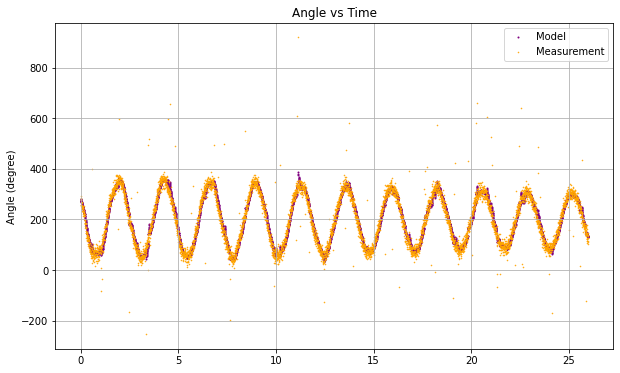

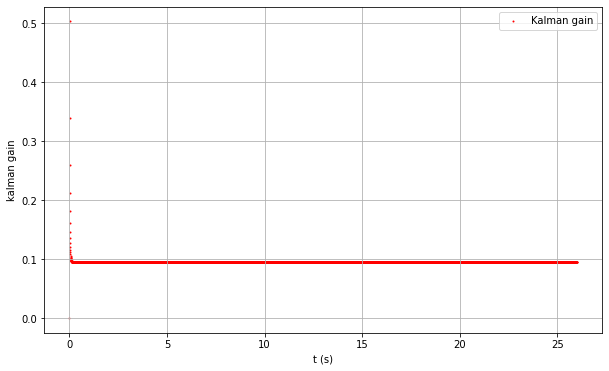

In [190]:
figure(figsize=(10,6))
scatter(time, x_opt, c='purple', label="Model", s = 1)
scatter(time, angle, c='orange', label="Measurement", s = 0.3)
title('Angle vs Time')
ylabel('Angle (degree)')
legend()
grid()
show()
figure(figsize=(10,6))
scatter(time, K, c='red',label="Kalman gain", s = 1)
ylabel('kalman gain')
xlabel('t (s)')
legend()
grid()
show()

# Task 2

Loading the chessboard images

In [191]:
!unzip Images.zip

Archive:  Images.zip
replace Images/img (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Using the code from this [link](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html) and collaborating with Seif Farag we can proceed By using opencv with python, we calibrate the camera and get the camera parameters. 

Then we remove the lens distortion and
apply multiple operations to get an image with segmented objects. 


The main idea is to find the connected
components in the image. The largest area of a connected component coresponds to the object in interest
to measure. 

To map points in the image coordinates to points in the world coordinates we need to compute
the rotation and the translation of the camera relative to the calibration pattern. 

To measure the object we convert the top-left and the top-right corners of the bounding box into world coordinates. Then we compute
the Euclidean distance between them in millimeters. 

### prepare object points

In [192]:
# prepare object points
nx = 9 
ny = 7 
l = 21

### Calibrating the camera

In [193]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
objp = np.zeros((ny*nx, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

Reading all the images

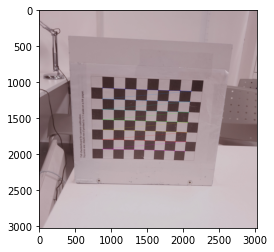

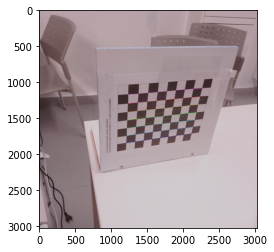

Images/img (3).jpg
Images/img (4).jpg


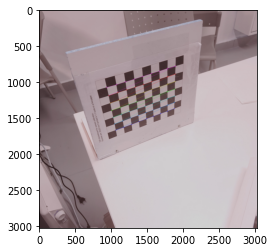

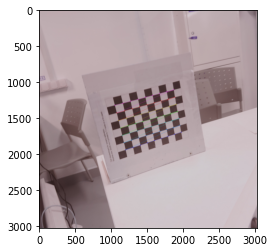

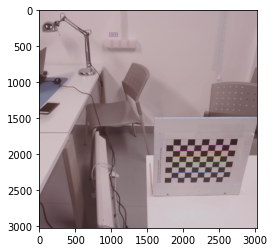

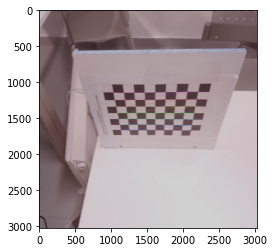

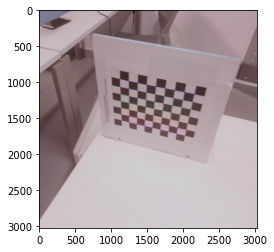

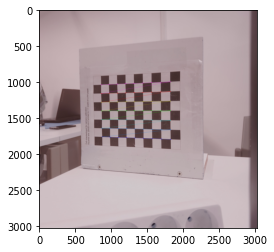

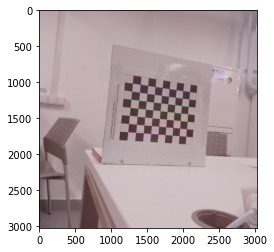

Images/img (12).jpg
Images/img (13).jpg


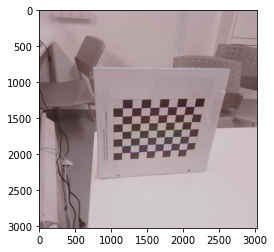

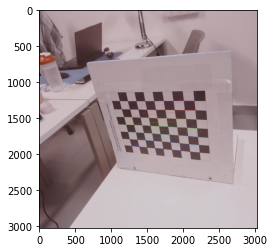

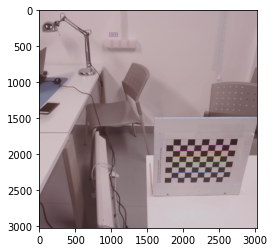

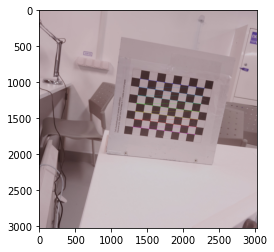

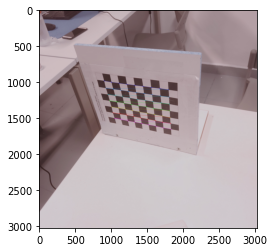

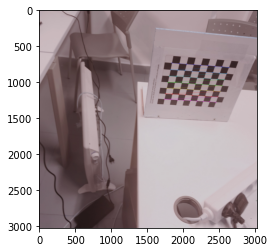

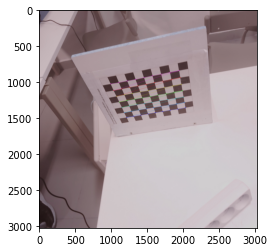

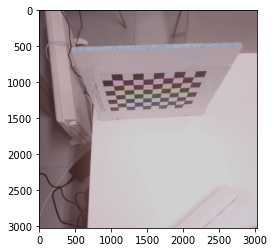

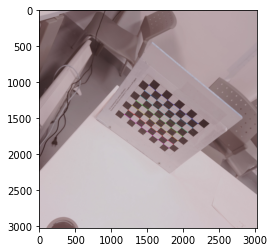

Images/img (23).jpg
Images/img (24).jpg


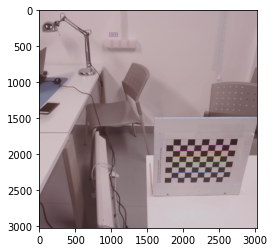

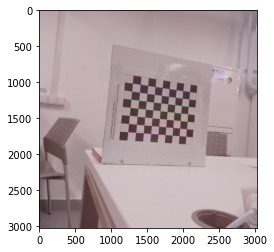

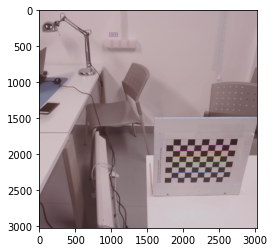

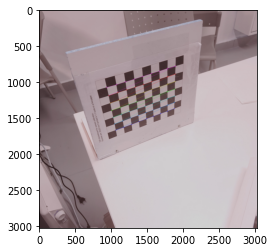

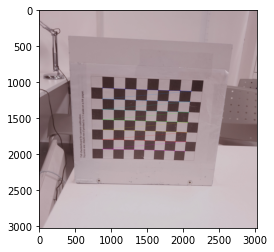

In [194]:
images = []

for i in range (1,30): 
    fname = f'Images/img ({i}).jpg'
    img = cv2.imread(f'Images/img ({i}).jpg') 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    images.append(gray)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points (after refining them)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (9, 9), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        plt.ion()
        img = cv2.drawChessboardCorners(img, (nx, ny), corners2, ret)

        plt.imshow(img)
        plt.show()
        plt.pause(0.1)
    else:
        print(fname)

Calibration

In [195]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Store the parameters in the folder
np.savez('Parameters', ret=ret, matrix=mtx, distance=dist, rotation=rvecs, translation=tvecs)

Undistortion

In [196]:
# Read in an image
img = cv2.imread('test.jpg') #you may put here any photos (t1-t41)
h,  w = img.shape[:2]

#Returns the new (optimal) camera matrix based on the free scaling parameter.
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
# undistortion
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
#cv2.imwrite('object_measure.png', dst)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]


Plotting the Results

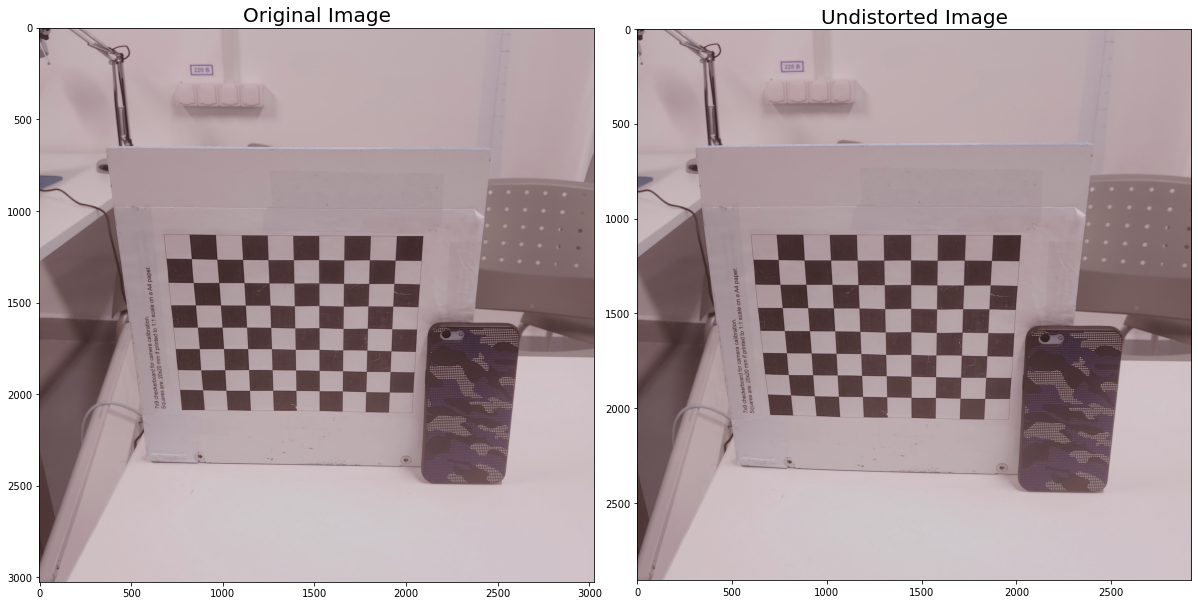

In [197]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

Reprojection error

In [198]:
tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error

print("reprojection error = %.2f \n" % (tot_error/len(objpoints)))

reprojection error = 0.18 



### Estimating the object size

In [229]:
#Reading a test image
im = cv2.imread('test6.jpg')
h, w = im.shape[:2]

In [230]:
#Undistort the image
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

dst = cv2.undistort(im, mtx, dist, None, newcameramtx)
cv2.imwrite('object_size_undistorted.jpg', dst)

True

In [231]:
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
im = dst

In [232]:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# Finding the chess board corners of photo
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
corners2 = cv2.cornerSubPix(gray, corners, (9, 9), (-1, -1), criteria)

In [233]:
image_corn = cv2.drawChessboardCorners(im, (nx, ny), corners2, ret)
xy = corners[11][0]-corners[0][0]
x = xy[0]
y = xy[1]
ratio_x = x/l
ratio_y = y/l
ratio = (ratio_x+ratio_y)/2
f = (0.5*(mtx[0][0]+mtx[1][1]))/ratio

In [234]:
#Finding the WhiteBoard Eraser
COLOR_MIN = np.array([0, 0, 0], np.uint8)
COLOR_MAX = np.array([100, 100, 100], np.uint8)
frame_threshed = cv2.inRange(im, COLOR_MIN, COLOR_MAX)
imgray = frame_threshed
ret, thresh = cv2.threshold(frame_threshed, 127, 255, 0)

In [235]:
#Find contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt=contours[max_index]
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 2)

array([[[187, 170, 181],
        [186, 169, 180],
        [185, 168, 179],
        ...,
        [167, 148, 162],
        [165, 147, 160],
        [168, 150, 163]],

       [[186, 169, 180],
        [187, 170, 181],
        [186, 169, 180],
        ...,
        [166, 147, 162],
        [167, 148, 163],
        [168, 149, 164]],

       [[186, 169, 180],
        [187, 170, 181],
        [187, 170, 181],
        ...,
        [166, 148, 161],
        [167, 149, 163],
        [168, 149, 164]],

       ...,

       [[170, 153, 166],
        [171, 154, 167],
        [170, 153, 166],
        ...,
        [209, 195, 207],
        [209, 195, 207],
        [209, 195, 207]],

       [[172, 155, 168],
        [172, 155, 168],
        [171, 154, 167],
        ...,
        [209, 195, 207],
        [208, 194, 206],
        [209, 195, 207]],

       [[ 32,  29,  32],
        [ 43,  39,  42],
        [ 59,  53,  57],
        ...,
        [208, 194, 206],
        [208, 194, 206],
        [209, 195, 207]]

Plotting

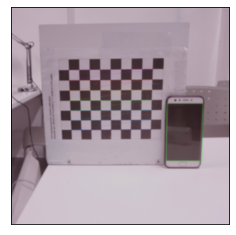

In [236]:
plt.imshow(im, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])
plt.show()

In [237]:
#Calculating the real size of the object
View_Distance = 36
width = View_Distance*w/(ratio*f)
height = View_Distance*h/(ratio*f)
print("The width of the object = %.2f cm" % width, "\nThe height of the object = %.2f cm" % height)

The width of the object = 7.61 cm 
The height of the object = 11.97 cm


### Estimating the distance between the object and the camera

As we know the shape of the object, we can compute the distance from camera to the object on any other image


 The distance between the image plane and the object = 35.12 cm


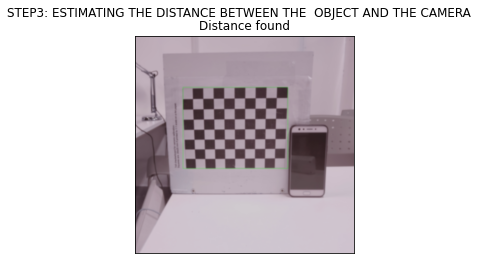

In [238]:
im = cv2.imread('test6.jpg')
h,  w = im.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))

dst = cv2.undistort(im, mtx, dist, None, newcameramtx)
cv2.imwrite('object_distance_calibrated.png', dst)
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
im = dst

COLOR_MIN = np.array([0, 0, 0], np.uint8)
COLOR_MAX = np.array([100, 100, 100], np.uint8)
frame_threshed = cv2.inRange(im, COLOR_MIN, COLOR_MAX)
imgray = frame_threshed
ret, thresh = cv2.threshold(frame_threshed, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt = contours[max_index]
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(im, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])  
print(" The distance between the image plane and the object = %.2f cm" % (height*mtx[1][1]/h))
plt.suptitle('STEP3: ESTIMATING THE DISTANCE BETWEEN THE  OBJECT AND THE CAMERA')
plt.title('Distance found')
plt.show()
